# Code to simulate LMG Model
We have the following Hamiltonian
\begin{align}
H&=-\frac{J}{N}\sum_{i<j}\sigma_{i}^{z}\sigma_{j}^{z}+\gamma\sigma_{i}^{y}\sigma_{j}^{y}-\Gamma\sum_{i}\sigma_{i}^{x}
\end{align}
This reduces to (See ~/Dropbox/Research_Projects_Current/LMG_quench/LMG_quench.lyx),
\begin{equation}
H=-\frac{J}{2}\left(1+\gamma\left(2+\frac{N}{2}\right)\right)-\frac{J\left(2-\gamma\right)}{N}S_{z}^{2}+\frac{J\gamma}{2N}\left(S_{+}^{2}+S_{-}^{2}\right)-\Gamma\left(S_{+}+S_{-}\right)
\end{equation}
with the matrix elements,
\begin{align}
\left\langle S=\frac{N}{2},M\right|H\left|S=\frac{N}{2},M^{\prime}\right\rangle  & =\delta_{MM^{\prime}}\left[-\frac{J}{2}\left(1+\gamma\left(1+\frac{2S\left(S+1\right)}{N}\right)\right)-\frac{J\left(2-\gamma\right)}{N}M^{2}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}-2}\left[\frac{J\gamma}{2N}\sqrt{\left(S\left(S+1\right)-\left(M+2\right)\left(M+1\right)\right)\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}+2}\left[\frac{J\gamma}{2N}\sqrt{\left(S\left(S+1\right)-\left(M-2\right)\left(M-1\right)\right)\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}-1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M+1\right)\right)}\right]+\nonumber \\
 & \ \ \ \delta_{MM^{\prime}+1}\left[-\Gamma\sqrt{\left(S\left(S+1\right)-M\left(M-1\right)\right)}\right]
\end{align}

In [185]:
import numpy as np
from scipy import linalg as LA
import scipy.sparse.linalg as spla
from matplotlib import pyplot as plt
#for Latex font on figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [59]:
#define Hamiltonian parameters
class Ham_params:
    def __init__(self, N:int,S:float,J:float,γ:float,Γ:float):
        self.N=N #number of spins, keep it even
        self.S=S #spin sector
        self.J=J #Ising hopping
        self.γ=γ #anisotropy factor
        self.Γ=Γ #Transverse field

In [111]:
def LMG_matrixelement(X:Ham_params,M:float,Mprime:float):
    #computes the matrix element <S,M|H|S,M'>
    value=0 
    if abs(M-Mprime)<10**-5:
        value= (X.J/2)*(1+X.γ*(1-2*X.S*(X.S+1)/X.N))-(M**2)*X.J*(2-X.γ)/X.N
    elif abs(M-(Mprime-2))<10**-5:
        value= X.J*X.γ/(2*X.N)*np.sqrt((X.S*(X.S+1)-(M+2)*(M+1))*(X.S*(X.S+1)-M*(M+1)))
    elif abs(M-(Mprime+2))<10**-5:
        value= X.J*X.γ/(2*X.N)*np.sqrt((X.S*(X.S+1)-(M-2)*(M-1))*(X.S*(X.S+1)-M*(M-1)))
    elif abs(M-(Mprime-1))<10**-5:
        value=-X.Γ*np.sqrt(X.S*(X.S+1)-M*(M+1))
    elif abs(M-(Mprime+1))<10**-5:
        value=-X.Γ*np.sqrt(X.S*(X.S+1)-M*(M-1))
    return value         
def LMG_generateHam(X:Ham_params):
    #Generate (2*S+1,2*S+1) matrix.
    Ham=np.zeros((2*X.N+1,2*X.N+1))
    Marr=np.linspace(-X.N//2,X.N//2,2*X.N+1)
    for p in range(np.size(Marr)):
        for q in range(np.size(Marr)):
            Ham[p,q]=LMG_matrixelement(X,Marr[p],Marr[q])
    return Ham
def magnetization(state,N):
    #takes in a column vector denoting wavefunction, and calcuates the total Sz squared
    Marr=np.linspace(-N//2,N//2,2*N+1)
    magsq=4/N**2*np.sum(np.square(np.abs(state)*Marr))
    return magsq
    

In [135]:
paramvals=Ham_params(N=10,S=50,J=1,γ=0.1,Γ=0)
Ham=LMG_generateHam(paramvals)
(Ham.transpose() == Ham).all() #check hermitian
#diagonalize
Energies,Eigenvecs=LA.eig(Ham) #full diagonalize
SEnergies,SEigenvecs=spla.eigs(Ham,k=1,which="SR")#sparse diagonalize
idx = Energies.argsort()  
Energies =Energies[idx]
Eigenvecs = Eigenvecs[:,idx]

(-49.207628913906916+0j)


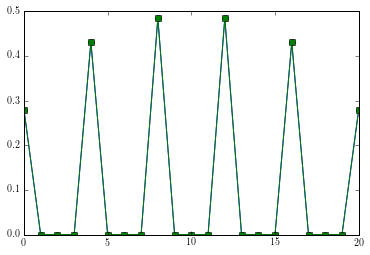

In [186]:
plt.plot(abs(Eigenvecs[:,0]),'-o')
plt.plot(abs(SEigenvecs[:,0]),'-s')
np.disp(Energies[0])

In [217]:
#calculate magnetization as a function of magnetic field
Γarr=np.linspace(0.,2,20)
Larr=np.arange(100,800,100)#choose even
magsqlist=np.ones([np.size(Γarr),np.size(Larr)])
for q in range(np.size(Larr)):
    L=Larr[q]
    for p in range(np.size(Γarr)):
        print([p,q], end='\r', flush=True)
        paramvals=Ham_params(N=L,S=L/2,J=1,γ=0.0,Γ=Γarr[p]) 
        Ham=LMG_generateHam(paramvals)
        GSenergy,vec=spla.eigs(Ham,k=1,which="SR")
        GState=vec[:,0]
        #Energies, Eigenvecs = LA.eig(Ham)
        #GSenergy=Energies[0]
        #GState=Eigenvecs[:,0]
        magsqlist[p,q]=magnetization(GState,paramvals.N)


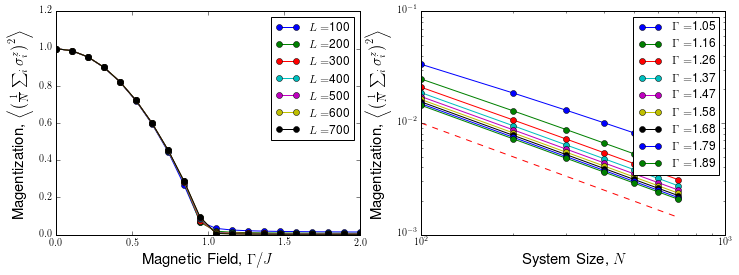

In [250]:
#plotting
α=1 
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(Γarr, magsqlist,'-o')
plt.ylim([0,1.2])
plt.xlabel("Magnetic Field, $\\Gamma/J$",fontsize=15)
plt.ylabel("Magentization, $\\left\\langle\\left(\\frac{1}{N}\\sum_i \\sigma^z_i\\right)^2\\right\\rangle$",fontsize=15)
leg = np.array(['$L=$%d' % p for p in Larr])
plt.legend(leg)
ax=plt.subplot(1,2,2)
plt.loglog(Larr,np.transpose(magsqlist[10:-1,:]),'-o')
plt.loglog(Larr,(Larr.astype(float))**(-α)*(float(Larr[0])**(α)*10**(-2)),'--')
#plt.ylim([0,1.2])
plt.xlabel("System Size, $N$",fontsize=15)
plt.ylabel("Magentization, $\\left\\langle\\left(\\frac{1}{N}\\sum_i \\sigma^z_i\\right)^2\\right\\rangle$",fontsize=15)
leg = np.array(['$\Gamma=$%0.2f' % p for p in Γarr[10:-1]])
plt.legend(leg)

In [240]:
(Larr.astype(float))**(-1.)*(float(Larr[0])**3)

array([10000.        ,  5000.        ,  3333.33333333,  2500.        ,
        2000.        ,  1666.66666667,  1428.57142857])

In [173]:
np.shape(np.multiply(,Marr))

(201, 201)

In [178]:
np.abs(GState)[:,0]

array([8.09542870e-01, 1.91842241e-14, 2.42956997e-15, 1.39090368e-16,
       9.89417873e-16, 1.43314728e-16, 1.40393513e-16, 5.18410311e-16,
       5.35671968e-16, 1.44103100e-17, 2.52169625e-16, 1.84543316e-16,
       4.79108282e-17, 2.50725363e-16, 3.03571314e-16, 4.34183246e-16,
       3.06077365e-16, 1.03789664e-16, 2.21721688e-17, 1.62110158e-17,
       1.23633320e-16, 9.81491144e-17, 5.93699374e-17, 2.61391618e-17,
       5.17728384e-18, 1.25738835e-18, 9.41426421e-18, 9.69166543e-18,
       2.62599190e-17, 1.43292369e-17, 1.78384573e-17, 2.11029252e-17,
       4.06780752e-17, 5.79690413e-17, 4.34706824e-17, 6.48815041e-17,
       4.94734096e-17, 1.75944034e-17, 1.08717823e-17, 5.72960080e-17,
       3.02490660e-17, 4.65012422e-17, 5.41807679e-17, 2.32132427e-17,
       1.27691976e-17, 2.95486051e-18, 9.90061406e-19, 1.98469861e-17,
       1.74351252e-17, 1.88426384e-18, 3.20273905e-18, 1.84846394e-18,
       1.27024133e-17, 5.18433556e-18, 1.79489506e-17, 1.66174781e-17,
      

\subsection{Quench Protocol}
We start with an initial state and initial Hamiltonian,
\begin{align}
|\psi_{0}\rangle&=\\
H_0&=
\end{align}

In [163]:
Marr

array([-50. , -49.5, -49. , -48.5, -48. , -47.5, -47. , -46.5, -46. ,
       -45.5, -45. , -44.5, -44. , -43.5, -43. , -42.5, -42. , -41.5,
       -41. , -40.5, -40. , -39.5, -39. , -38.5, -38. , -37.5, -37. ,
       -36.5, -36. , -35.5, -35. , -34.5, -34. , -33.5, -33. , -32.5,
       -32. , -31.5, -31. , -30.5, -30. , -29.5, -29. , -28.5, -28. ,
       -27.5, -27. , -26.5, -26. , -25.5, -25. , -24.5, -24. , -23.5,
       -23. , -22.5, -22. , -21.5, -21. , -20.5, -20. , -19.5, -19. ,
       -18.5, -18. , -17.5, -17. , -16.5, -16. , -15.5, -15. , -14.5,
       -14. , -13.5, -13. , -12.5, -12. , -11.5, -11. , -10.5, -10. ,
        -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,  -6. ,  -5.5,
        -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,  -1.5,  -1. ,
        -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,
         4. ,   4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,
         8.5,   9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,
        13. ,  13.5,

In [28]:
#quench protocol
prequenchparams=Ham_params(N=100,S=50,J=1,γ=0.5,Γ=1)
postquenchparams=Ham_params(N=100,S=50,J=1,γ=0.5,Γ=2)
initstate=
Ham=LMG_generateHam(postquenchparamvals)
tarr
U_t=LA.expm(-1j*Ham*t)